# Importing libraries and Reading Datasets

In [1]:
import pandas as pd
import numpy as np
import re
import warnings, random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

place_data = pd.read_csv(r"C:\Users\jaske\OneDrive\Desktop\studies\intro to data science\CPI.csv", skiprows = 1)
jobs_data = pd.read_csv(r"C:\Users\jaske\OneDrive\Desktop\studies\intro to data science\DS_JOBS_2019_2022.csv")
final_cleaned_data = r"C:\Users\jaske\Downloads\cleaned_withImputation_removedOutliers.csv"

# Getting only Australian cities

In [2]:
cities = list(map(str.lower, place_data.columns[1:-1]))
cities

['sydney',
 'melbourne',
 'brisbane',
 'adelaide',
 'perth',
 'hobart',
 'darwin',
 'canberra']

# Filtering Data

In [3]:
#Getting Jobs data for Australia and its cities
jobs_data = jobs_data[jobs_data["nation"] == "Australia"]
jobs_data["city"] = jobs_data["city"].str.lower()
jobs_data["city"].replace(to_replace = "act", value = "canberra", inplace=True )
jobs_data = jobs_data[jobs_data["city"].isin(cities)]

jobs_data.reset_index(drop=True, inplace=True)
jobs_data["city"].unique()

array(['sydney', 'canberra', 'melbourne', 'perth', 'brisbane', 'darwin',
       'adelaide', 'hobart'], dtype=object)

In [4]:
#Unique values in each column
unique_df = pd.DataFrame()

for i in jobs_data.columns:
    unique_df.at[0, i] = str(len(jobs_data[i].unique()))

print("Number of unique values in each column")
unique_df

Number of unique values in each column


,jobId,jobTitle,jobClassification,jobSubClassification,advertiserName,advertiserId,companyId,companyName,companyRating,listingDate,expiryDate,teaser,nation,state,city,area,suburb,workType,salary_string,isRightToWorkRequired,desktopAdTemplate,mobileAdTemplate,companyProfileUrl,seekJobListingUrl,R,Python,Matlab,SQL,Stata,Minitab,SPSS,Ruby,C,Scala,Tableau,Java,Hadoop,SAS,Julia,Knime,D3,Clojure,Haskell,Lisp,Golang,Spark,Javascript,F.,Fortran,first_seen,last_seen,recruiter
0,3807,1149,25,82,902,937,281,331,278,3588,1249,2275,1,9,8,17,197,6,875,3,2456,2944,1119,3807,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,772,858,2


In [5]:
#Count of nulls in each column
jobs_data.isna().sum()

null_df = pd.DataFrame()

for i in jobs_data.columns:
    null_df.at[0, i] = str(jobs_data[i].isna().sum())

print("Number of null values in each column")
null_df

Number of null values in each column


,jobId,jobTitle,jobClassification,jobSubClassification,advertiserName,advertiserId,companyId,companyName,companyRating,listingDate,expiryDate,teaser,nation,state,city,area,suburb,workType,salary_string,isRightToWorkRequired,desktopAdTemplate,mobileAdTemplate,companyProfileUrl,seekJobListingUrl,R,Python,Matlab,SQL,Stata,Minitab,SPSS,Ruby,C,Scala,Tableau,Java,Hadoop,SAS,Julia,Knime,D3,Clojure,Haskell,Lisp,Golang,Spark,Javascript,F.,Fortran,first_seen,last_seen,recruiter
0,0,0,0,0,0,0,2789,2396,2789,0,0,510,0,0,0,1137,893,0,2324,469,679,7,2396,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Removing Unwanted columns

In [6]:
jobs_data.columns

Index(['jobId', 'jobTitle', 'jobClassification', 'jobSubClassification',
       'advertiserName', 'advertiserId', 'companyId', 'companyName',
       'companyRating', 'listingDate', 'expiryDate', 'teaser', 'nation',
       'state', 'city', 'area', 'suburb', 'workType', 'salary_string',
       'isRightToWorkRequired', 'desktopAdTemplate', 'mobileAdTemplate',
       'companyProfileUrl', 'seekJobListingUrl', 'R', 'Python', 'Matlab',
       'SQL', 'Stata', 'Minitab', 'SPSS', 'Ruby', 'C', 'Scala', 'Tableau',
       'Java', 'Hadoop', 'SAS', 'Julia', 'Knime', 'D3', 'Clojure', 'Haskell',
       'Lisp', 'Golang', 'Spark', 'Javascript', 'F.', 'Fortran', 'first_seen',
       'last_seen', 'recruiter'],
      dtype='object')

In [7]:
unwanted_columns = ["jobId", "advertiserId", "companyId", "teaser", "desktopAdTemplate", "companyProfileUrl", "seekJobListingUrl"]
jobs_data = jobs_data.drop(unwanted_columns, axis=1)

# Cleaning Data

In [8]:
#Classifying on jobs to make jobtype
jobs_data["jobType"] = None

for i in range(len(jobs_data)):
    if("scientist" in jobs_data["jobTitle"][i].lower()):
        jobs_data["jobType"][i] = "Data Scientist"
    elif("analyst" in jobs_data["jobTitle"][i].lower()):
        jobs_data["jobType"][i] = "Data Analyst"
    elif("engineer" in jobs_data["jobTitle"][i].lower()):
        jobs_data["jobType"][i] = "Data Engineer"
    elif("manager" in jobs_data["jobTitle"][i].lower()):
        jobs_data["jobType"][i] = "Analytics Manager"
    elif("develop" in jobs_data["jobTitle"][i].lower()):
        jobs_data["jobType"][i] = "Data Architect"
    else:
        jobs_data["jobType"][i] = "Other"

In [9]:
#Calculating salary from salarystring
jobs_data["salary"] = None

for i in range(len(jobs_data)):
    value = str(jobs_data["salary_string"][i])
    
    remove_list = [',', 'per day', 'per annum', 'p.a.', 'p.d.', 'p/d', 'p/a', '.00']
    for x in remove_list:
        value = value.replace(x, "")
    
    value = re.sub('\d+[\.]*\d*[%]+', '', value)
    value = re.sub('[\.]*\d*[%]+', '', value)
    value = re.sub('[\.]+\d*', '', value)
    value = re.findall(r'[-]*\s*\d+\s*\w{1}', value)
    
    try:
        jobs_data["salary"][i] = re.sub('\D', '', value[-1].replace("k", "000").replace("K", "000"))
    except:
        jobs_data["salary"][i] = None

jobs_data["salary"] = pd.to_numeric(jobs_data["salary"])
jobs_data["salary"] = jobs_data["salary"].abs()

In [10]:
#Calculating total skills for each job
skill_list = ['R', 'Python', 'Matlab', 'SQL', 'Stata', 'Minitab', 'SPSS', 'Ruby', 'C', 'Scala', 'Tableau', 'Java', 'Hadoop', 'SAS', 'Julia', 'Knime', 'D3', 'Clojure', 'Haskell', 'Lisp', 'Golang', 'Spark', 'Javascript', 'F.', 'Fortran']
jobs_data["total_skills"] = jobs_data[skill_list].sum(axis = 1)

In [11]:
#Parsing experience from online ads
jobs_data["experience"] = None

for i in range(len(jobs_data)):
    exp = None
    try:
        exp = list(filter(lambda sentence: ("year" in sentence)or("yr" in sentence) , jobs_data["mobileAdTemplate"][i].split(".")))[-1]
        exp = re.findall('\d+\s*[+]*\s*[y]{1}', exp)[0]
        exp = float(re.sub('\D', '', exp))
        jobs_data["experience"][i] = random.choice(range(5, 16)) if(exp >= 15) else exp
    except:
        jobs_data["experience"][i] = None
jobs_data["experience"] = jobs_data["experience"].astype('float64')

# Imputation using Mean Value

In [12]:
#Imputing mean values based on state level for experience column
for i in jobs_data["state"].unique():
    impute_value = round(jobs_data["experience"][jobs_data["state"] == i].mean(), 2)
    if(str(impute_value) == "nan"):
        impute_value = round(jobs_data["experience"].mean(), 2)
    
    print(i + " : " + str(impute_value))
    jobs_data.loc[jobs_data["state"] == i, "experience"] = jobs_data.loc[jobs_data["state"] == i, "experience"].fillna(impute_value)

New South Wales : 4.72
Australian Capital Territory : 3.26
Victoria : 5.01
Western Australia : 5.08
Queensland : 4.7
Northern Territories : 2.0
South Australia : 4.78
Tasmania : 3.0
Northern Territory : 4.7


# Imputation using Linear regression

In [13]:
lrm_data = jobs_data[["state", "salary", "total_skills", "experience"]]

for i in lrm_data["state"].unique():
    lrm_train = lrm_data.loc[lrm_data['salary'].notnull(), ][lrm_data['state'] == i]
    
    independant = lrm_train[["total_skills", "experience"]]
    dependant = lrm_train["salary"]
    
    lrm = LinearRegression().fit(independant, dependant)
    for j in jobs_data[jobs_data.isnull().any(axis=1)][jobs_data["state"] == i].index:
        jobs_data["salary"][j] = round(lrm.predict([[jobs_data["total_skills"][j], jobs_data["experience"][j]]])[0], 2)

# Outlier Removal

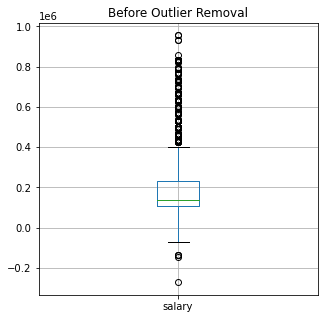

In [14]:
jobs_data.boxplot(column = "salary", figsize=(5, 5))
plt.title("Before Outlier Removal")
plt.show()

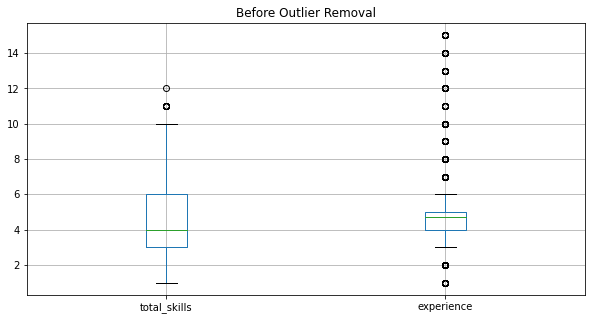

In [15]:
jobs_data.boxplot(column = ["total_skills", "experience"], figsize=(10, 5))
plt.title("Before Outlier Removal")
plt.show()

In [16]:
jobs_data["outlier"] = 0

for col in ["salary", "total_skills", "experience"]:
    
    q3, q1 = np.percentile(jobs_data[col], [75 ,25])
    iqr = q3 - q1

    upper = q3 + (1.5*iqr)
    lower = q1 - (1.5*iqr)
    jobs_data.loc[((jobs_data[col] < lower) | (jobs_data[col] > upper)), "outlier"] = 1

jobs_data = jobs_data[jobs_data["outlier"] == 0]
del jobs_data["outlier"]

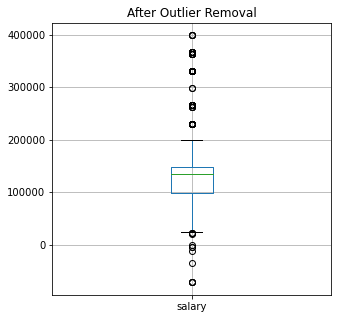

In [17]:
jobs_data.boxplot(column = "salary", figsize=(5, 5))
plt.title("After Outlier Removal")
plt.show()

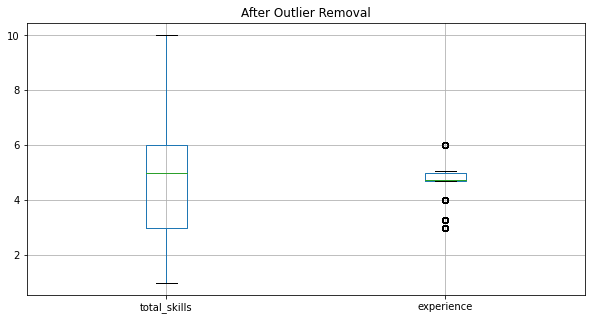

In [18]:
jobs_data.boxplot(column = ["total_skills", "experience"], figsize=(10, 5))
plt.title("After Outlier Removal")
plt.show()

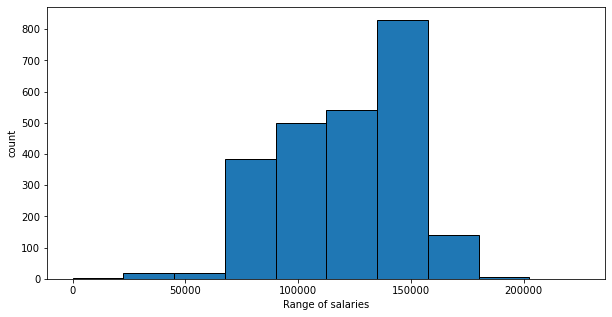

In [19]:
plt.figure(figsize = (10,5))
plt.hist(jobs_data[~jobs_data["salary"].isnull()]["salary"], range=[0,225000], edgecolor = "#000000")
plt.ylabel("count")
plt.xlabel("Range of salaries")
plt.show()

# Save Cleaned data

In [20]:
jobs_data.to_csv(final_cleaned_data, index = False)